<a href="https://colab.research.google.com/github/PauDK/Deceptive-Review-Detection/blob/main/BERT_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-text
!pip install tf-models-official

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 15.3 MB/s 
     |████████████████████████████████| 588.3 MB 6.5 kB/s 
     |████████████████████████████████| 1.7 MB 53.5 MB/s 
     |████████████████████████████████| 439 kB 65.7 MB/s 
     |████████████████████████████████| 6.0 MB 3.3 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.

In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [9]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/fake-reviews-detection/source/common/')

In [14]:
import data_preprocessing

root_dir = "/content/drive/My Drive/Colab Notebooks/fake-reviews-detection"
df = data_preprocessing.import_raw_data(root_dir)
display(df[:5])

,Label,Rating,Ori_Review
0,1,1,"For 250 dollars, cheapest room available at th..."
1,1,1,Me and my business associate had a job in Chic...
2,1,1,My stay at the Hyatt Regency was an experience...
3,1,1,"Upon first inspection, Sofitel Chicago Water T..."
4,1,1,I wish to express my dissatisfaction with my s...


In [15]:
df.to_csv(os.path.join(root_dir, 'data/labeled-data/Chicago_Hotel_Reviews.csv'))

In [51]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import torch

from matplotlib import pyplot as plt
from tensorflow import keras
from official.nlp import optimization
from pprint import pprint
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

In [18]:
sdf = pd.read_csv("/content/drive/My Drive/Colab Notebooks/fake-reviews-detection/data/labeled-data/Chicago_Hotel_Reviews.csv", index_col=0)
df = df.drop('Rating', axis=1)
df.loc[df['Label'] == -1, 'Label'] = 0
X = df['Ori_Review']
y = df['Label']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [23]:
preprocessor = hub.load("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

In [24]:
text_inputs = [keras.layers.Input(shape=(), dtype=tf.string)]
tokenize = hub.KerasLayer(preprocessor.tokenize)
tokenized_inputs = [tokenize(segment) for segment in text_inputs]

seq_length = 512  # Set sequence length
bert_pack_inputs = hub.KerasLayer(
    preprocessor.bert_pack_inputs,
    arguments=dict(seq_length=seq_length))
preprocessed_text = bert_pack_inputs(tokenized_inputs)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


{'whiskers': [<matplotlib.lines.Line2D at 0x7f0eb8dd7ed0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0eb8e126d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0eb8dd7390>],
 'medians': [<matplotlib.lines.Line2D at 0x7f0eb8ddbad0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f0eb8ddbc10>],
 'means': []}

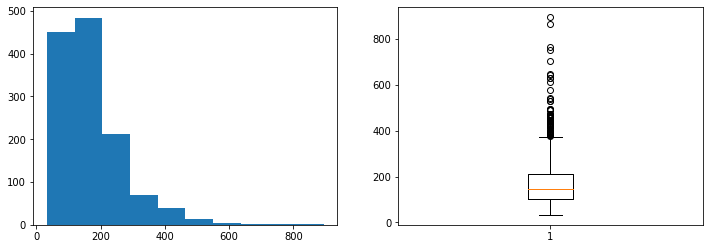

In [25]:
sizes = []
tokens = tokenize(X_train)
for i in range(tokens.shape[0]):
  sizes.append(tokens[i].shape[0])

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(12)
ax1.hist(sizes)
ax2.boxplot(sizes)

In [26]:
text_inputs

[<KerasTensor: shape=(None,) dtype=string (created by layer 'input_1')>]

In [27]:
preprocessed_text

{'input_word_ids': <KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'keras_layer_1')>,
 'input_type_ids': <KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'keras_layer_1')>,
 'input_mask': <KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'keras_layer_1')>}

In [28]:
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=True)

In [29]:
# Train all BERT layers as suggested by BERT developers
bert_encoder.trainable = True

# Bert layers
outputs = bert_encoder(preprocessed_text)

# Dense layers
l = keras.layers.Dense(1, activation='sigmoid', name="output") (outputs['pooled_output'])

# Use inputs and outputs to construct a final model
model = keras.Model(inputs=text_inputs, outputs = [l])

In [30]:
epochs = 3
batch_size = 8
init_lr = 3e-5  # best of [5e-5, 3e-5, 2e-5]

train_data_size = X_train.shape[0]
steps_per_epoch = train_data_size // batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = num_train_steps // 10

test_data_size = X_test.shape[0]

In [31]:
optimizer = optimization.create_optimizer(
      init_lr=init_lr,
      num_train_steps=num_train_steps,
      num_warmup_steps=num_warmup_steps,
      optimizer_type='adamw')

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics='accuracy')

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       (None, None, None)   0           ['input_1[0][0]']                
                                                                                                  
 keras_layer_1 (KerasLayer)     {'input_word_ids':   0           ['keras_layer[0][0]']            
                                (None, 512),                                                      
                                 'input_type_ids':                                                
                                (None, 512),                                                  

In [32]:
bert_encoder.trainable = False
model.fit(X_train,
          y_train,
          steps_per_epoch=steps_per_epoch,
          epochs=epochs,
          validation_data=(X_test, y_test))

Epoch 1/3
160/160 [==============================] - 196s 1s/step - loss: 0.5230 - accuracy: 0.7406 - val_loss: 0.3922 - val_accuracy: 0.8344
Epoch 2/3
160/160 [==============================] - 179s 1s/step - loss: 0.2553 - accuracy: 0.9187 - val_loss: 0.3976 - val_accuracy: 0.8844
Epoch 3/3
160/160 [==============================] - 178s 1s/step - loss: 0.1069 - accuracy: 0.9688 - val_loss: 0.4439 - val_accuracy: 0.8938


In [33]:
prediction = model.predict(X_test)
prediction_real = model.predict(X_test[y_test == 0])
prediction_fake = model.predict(X_test[y_test == 1])

5/5 [==============================] - 6s 1s/step


In [34]:
# Manual calculation of Model Performance parameters
true_negative = 0
false_positive = 0
for val in prediction_real:
  if val <= 0.5:
    true_negative+=1
  else:
    false_positive+=1

true_positive = 0
false_negative = 0
for val in prediction_fake:
  if val > 0.5:
    true_positive+=1
  else:
    false_negative+=1

accuracy_score = (true_positive + true_negative)/(true_positive + true_negative + false_positive + false_negative)
precision_score = true_positive/(true_positive + false_positive)
recall_score = true_positive/(true_positive + false_negative)
f1_score = 2 * precision_score * recall_score /(precision_score + recall_score)

print('BERT Model Performance:')
# print(f'True Positive: {true_positive}')
# print(f'True Negative: {true_negative}')
# print(f'False Positive: {false_positive}')
# print(f'False Negative: {false_negative}')
print('Accuracy: ' + '{:.2%}'.format(accuracy_score))
print('Precision: ' + '{:.2%}'.format(precision_score))
print('Recall: ' + '{:.2%}'.format(recall_score))
print('F1 Score: ' + '{:.2%}'.format(f1_score))

BERT Model Performance:
Accuracy: 89.38%
Precision: 83.80%
Recall: 96.77%
F1 Score: 89.82%


In [45]:
# Calculation of Model Performance parameters using sklearn library
y_pred = prediction.copy()
y_pred[prediction <= 0.5] = 0
y_pred[prediction > 0.5] = 1

print('BERT Model Performance:')
print('- Test Accuracy: ', "{:.1%}".format(accuracy_score(y_test, y_pred)))
print('- Test Precision Score: ', "{:.1%}".format(precision_score(y_test, y_pred)))
print('- Test Recall Score: ', "{:.1%}".format(recall_score(y_test, y_pred)))
print('- Test F1 Score: ', "{:.1%}".format(f1_score(y_test, y_pred)))
print('- Test AUC-ROC Score: ', "{:.1%}".format(roc_auc_score(y_test, y_pred)))

BERT Model Performance:
- Test Accuracy:  89.4%
- Test Precision Score:  83.8%
- Test Recall Score:  96.8%
- Test F1 Score:  89.8%
- Test AUC-ROC Score:  89.6%


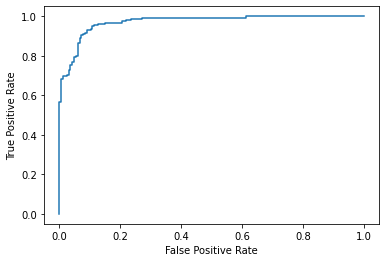

In [46]:
y_test_labels = np.array(y_test)

fpr, tpr, _ = roc_curve(y_test_labels, prediction)
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [47]:
demo_ind = np.random.choice(X_test.index)
realfake = 'Real' if y_test[demo_ind] == 0 else 'Fake'
prediction = model.predict([X_test[demo_ind]])
prediction_rf = 'Real' if prediction <= 0.5 else 'Fake'

print(f'{realfake} review to be fed to model:\n', X_test[demo_ind], '\n')
print(f'Model prediction: {prediction_rf}')

1/1 [==============================] - 1s 776ms/step
Fake review to be fed to model:
 The Omni Chicago Hotel offers all the great amenities in comfort that is expected of a luxury hotel, particularly speedy and easy wireless internet access and nice-sized plasma tv's. The windows are big enough to give a spectacular view of the city skyline while reclining on a great sofa in a comfortable and luxurious living room, before sleeping in a king-sized bed of either feather or foam pillows, which is particularly relaxing after taking a bath or shower in the spacious bathroom. An in-room massage appointment will add an additional relaxing aspect to the stay. There's even an exercise kit within the room for extra convince. However, the vast fitness center is just as worthy to use, as well as the whirlpool, Jacuzzi and the indoor swimming pool. Sunbathing is an easy activity to achieve via the two rooftop sundecks. A nice aspect that isn't so common to find is the ability to have small pets sta

In [54]:
main_save_path = '/content/drive/My Drive/Colab Notebooks/fake-reviews-detection/models'
saved_model_name = 'Fine_Tune_Bert_Test'
saved_model_path = os.path.join(main_save_path, saved_model_name)
save_options = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')

model.save(saved_model_path, include_optimizer=True, options=save_options)